In [1]:
from PrepareOriginalData import PrepareData
from NeuralNetworkCNN import NeuralNetwork
import numpy as np

# Some constants
taskType = 'all'
data_amount = 10
epochs = 3

# Load training set
p = PrepareData(path_images='data_vqa_feat', # Path to image features 
                        subset='train2014', # Desired subset: either train2014 or val2014
                        taskType=taskType, # 'OpenEnded', 'MultipleChoice', 'all'
                        cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1=#samples for debugging
                        output_path='data', # Path where we want to output temporary data
                        pad_length=32, # Number of words in a question (zero padded)
                        question_threshold=0, answer_threshold=0, # Keep only most common words
                        answers_sparse=True, questions_sparse=True, image_extractor = 'RawImages')
image_features, questions, answers, annotations = p.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Answers", answers.shape)
print("Dictionary size", p.dic_size)
print("Number of possible classes", np.max(answers) + 1)

# Save dictionary
p.dumpDictionary()

Using TensorFlow backend.


loading VQA annotations and questions into memory...
0:00:05.031968
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:06.848356
creating index...
index created!
Image features (20, 1)
Question features (20, 32)
Answers (20, 1)
Dictionary size 35
Number of possible classes 8


In [2]:
# Use this when using sparse representation
neuralnet = NeuralNetwork(image_features.shape[0],1024,questions.shape[1],p.dic_size,np.max(answers)+1, epochs = epochs, batchSize=32, bulkMultiplier=256, loss='sparse_categorical_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 32, 32)       1120        word_input[0][0]                 
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2304)         5275968     image_input[0][0]                
__________________________________________________________________________________________________
flatten_em

In [5]:
from scipy.misc import imread, imresize
mean_dataset = np.zeros((224,224,3))
print('subtracting mean...')
for i in range(len(image_features)):
    mean_dataset += imresize(imread(image_features[i][0], mode='RGB'), (224, 224)).astype(np.float32) / 255
mean_dataset /= len(image_features)

subtracting mean...


C:\Users\lanze\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
C:\Users\lanze\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


TypeError: Object of type 'ndarray' is not JSON serializable

In [8]:
#with open('data/train2014_mean.txt', 'w') as outfile:
#    mean_dataset.tofile(outfile)

In [3]:
with open('data/train2014_mean.txt', 'r') as infile:
    mean_dataset = np.fromfile(infile)

In [4]:
mean_dataset = mean_dataset.reshape((224,224,3))

In [3]:
# Concatenate in one matrix
X = np.hstack([image_features, questions])
print(X.shape)

(4966, 33)


In [5]:
neuralnet.get_model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 32)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 32, 32)       453696      word_input[0][0]                 
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2304)         5275968     image_input[0][0]                
__________________________________________________________________________________________________
flatten_em

In [5]:
# Train network
neuralnet.fit(image_features, questions, answers, mean_dataset)

(20, 1)
input is image stream
Train on 14 samples, validate on 6 samples
Epoch 1/3


MemoryError: 

In [4]:
# Test prediction on training set
from EvaluateModel import ProduceResult

# Predict
pred = neuralnet.predict(image_features[:100], questions[:100], 'weights/cnn_fully_trained.hdf5')
# pred = neuralnet.predict_current_state(X)
print(pred.shape)

# Evaluate
model_evaluator = ProduceResult(p._int_to_answer, p._answer_to_int, dataSubType='train2014')
model_evaluator.produce_results(pred, p._original_questions)
model_evaluator.evaluate(taskType=taskType)

subtracting mean...
input is image stream
(100, 1216)
loading VQA annotations and questions into memory...
0:00:04.966765
creating index...
index created!
Loading and preparing results...     
DONE (t=0.00s)
creating index...
index created!
computing accuracy
Finshed Percent: [--------------------] 0% Done computing accuracy


Overall Accuracy is: 42.10

Per Question Type Accuracy is the following:
what : 31.82
is there a : 100.00
is this : 43.33
is this a : 100.00
what color is the : 25.00
what is on the : 100.00
is the : 95.56
are these : 66.67
what is : 47.50
what is in the : 0.00
where is the : 0.00
what color are the : 0.00
where are the : 90.00
what animal is : 0.00
none of the above : 30.00
what kind of : 14.29
what is the : 0.00
are there any : 100.00
how : 0.00
what color is : 0.00
how many : 40.00
why is the : 0.00
who is : 0.00
is the person : 100.00
what color : 0.00
does this : 100.00
can you : 100.00
what is this : 0.00
does the : 33.33
is this person : 100.00
is : 100.00

ZeroDivisionError: float division by zero

In [5]:
# Load validation set and evaluate prediction on it
pt= PrepareOriginalData(path_images='data_vqa_feat', # Path to image features 
                        subset='val2014', # Desired subset: either train2014 or val2014
                        taskType=taskType, # 'OpenEnded', 'MultipleChoice', 'all'
                        cut_data=data_amount, # Percentage of data to use, 1 = All values, above 1 = 10 samples for debugging
                        output_path='data', # Path where we want to output temporary data
                        pad_length=32, # Number of words in a question (zero padded)
                        question_threshold=0, answer_threshold=0, # Keep only most common words
                        answers_sparse=True, questions_sparse=True, image_extractor='RawImages')
pt.loadDictionary('data/dictionary.json') # Use same dictionary as in training
image_features, questions, _, annotations = pt.load_data()
print("Image features", image_features.shape)
print("Question features", questions.shape)
print("Dictionary size", pt.dic_size)

loading VQA annotations and questions into memory...
0:00:04.025076
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:03.699528
creating index...
index created!
Image features (4860, 1)
Question features (4860, 32)
Dictionary size 2504


In [6]:
# Test prediction on validation set
#X = np.hstack([image_features, questions])
#print(X.shape)
pred = neuralnet.predict(image_features[:3], questions[:3], 'weights/cnn_fully_trained.hdf5')
# pred = neuralnet.predict_current_state(X)
print(pred.shape)

subtracting mean...
input is image stream
(3, 1216)


In [7]:
from EvaluateModel import ProduceResult
model_evaluator = ProduceResult(p._int_to_answer, p._answer_to_int, dataSubType='val2014')
answers = model_evaluator.produce_results(pred, pt._original_questions)
model_evaluator.evaluate(taskType=taskType)

loading VQA annotations and questions into memory...
0:00:02.837928
creating index...
index created!
Loading and preparing results...     
DONE (t=0.00s)
creating index...
index created!
computing accuracy
Finshed Percent: [--------------------] 0% Done computing accuracy


Overall Accuracy is: 66.67

Per Question Type Accuracy is the following:
what is the : 100.00
is the : 100.00
what : 0.00


Per Answer Type Accuracy is the following:
other : 50.00
yes/no : 100.00


loading VQA annotations and questions into memory...
0:00:03.253713
creating index...
index created!
Loading and preparing results...     
DONE (t=0.00s)
creating index...
index created!
computing accuracy


ZeroDivisionError: float division by zero

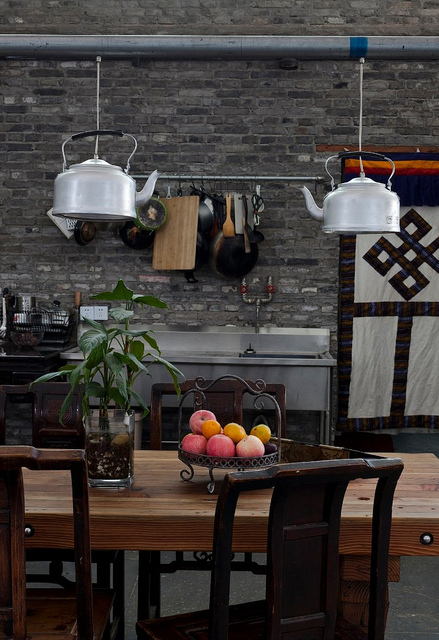

What is the table made of??
wood: 0.716162; metal: 0.0342161; brick: 0.0332612; 
Ground truth: wood
[{'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'wood', 'answer_confidence': 'maybe', 'answer_id': 8}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'wood', 'answer_confidence': 'yes', 'answer_id': 10}]


Is the food napping on the table??
yes: 0.517895; no: 0.480835; photographer: 9.61446e-05; 
Ground truth: no
[{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'no', 'an

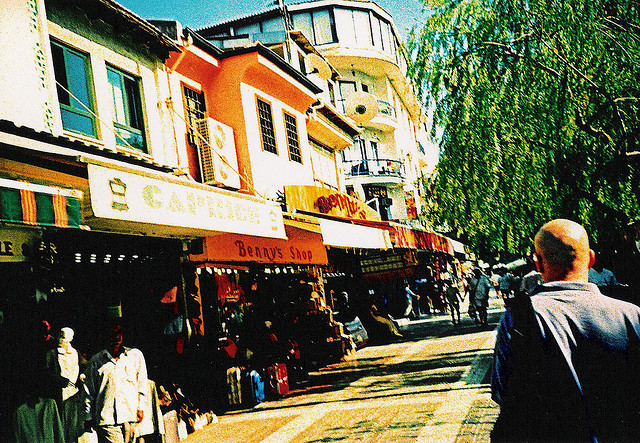

Is this an Spanish town??


IndexError: list index out of range

In [7]:
# Visualize prediction
from IPython.display import Image,display

def visualize_image_question_answer(index):
    if index % 3 == 0:
        subset_path = 'VQA/Images/mscoco/' + pt.subset + '/'
        image_path = subset_path + 'COCO_' + pt.subset + '_'+ str(annotations[index]["image_id"]).zfill(12) + '.jpg'
        display(Image(image_path,width=300))
        
    print(pt._original_questions[index]["question"] + '?')
    print(answers[index])
    print('Ground truth:', annotations[index]['multiple_choice_answer'])
    print(annotations[index]['answers'])
    print('\n')
    
for i in range(0,12):
    visualize_image_question_answer(i)